---
author: Zeel B Patel
badges: true
categories: ML
description: Exploring the use of SIRENs for climate modeling
title: Climate Modeling with SIRENs
date: '2023-07-01'
toc: true
---

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import pyproj
import numpy as np
import xarray as xr

import tensorflow as tf
from tensorflow.keras import layers, initializers, activations
from tensorflow.keras.applications.resnet50 import ResNet50

import matplotlib.pyplot as plt

2023-07-05 10:53:19.821615: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-05 10:53:20.503492: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def SIREN(input_dim, output_dim, features, activation_scale, dropout):
    first_init = lambda input_dim: initializers.RandomUniform(-1 / input_dim, 1 / input_dim)
    other_init = lambda input_dim: initializers.RandomUniform(-np.sqrt(6 / input_dim) / activation_scale, np.sqrt(6 / input_dim) / activation_scale)
    model = tf.keras.Sequential()
    model.add(layers.Dense(features[0], input_shape=(input_dim,), kernel_initializer=first_init(input_dim), activation=tf.sin))
    for i in range(1, len(features)):
        model.add(layers.Dense(features[i], kernel_initializer=other_init(features[i-1]), activation=tf.sin))
        model.add(layers.Dropout(dropout))
    model.add(layers.Dense(output_dim, kernel_initializer=other_init(features[-1]), activation='linear'))
    return model

def MLP(input_dim, output_dim, features, dropout):
    model = tf.keras.Sequential()
    model.add(layers.Dense(features[0], input_shape=(input_dim,), activation=activations.relu))
    for i in range(1, len(features)):
        model.add(layers.Dense(features[i], activation=activations.relu))
        model.add(layers.Dropout(dropout))
    model.add(layers.Dense(output_dim, activation='linear'))
    return model
    
def ResNet():
    resnet = ResNet50(include_top=False, weights=None, input_shape=(64, 32, 1), pooling='avg')
    model = tf.keras.Sequential()
    model.add(resnet)
    model.add(layers.Dense(2048, activation='relu'))
    model.add(layers.Dense(32768, activation='linear'))
    return model

In [3]:
data5 = xr.open_dataset("../data/2m_temperature_2018_5.625deg_Jan.nc").to_dataframe().reset_index()
data1 = xr.open_dataset("../data/2m_temperature_2018_1.40625deg_Jan.nc").to_dataframe().reset_index()

In [4]:
data5.head()

,lon,lat,time,t2m
0,0.0,-87.1875,2018-01-01 00:00:00,250.728180
1,0.0,-87.1875,2018-01-01 01:00:00,250.468552
2,0.0,-87.1875,2018-01-01 02:00:00,250.250931
3,0.0,-87.1875,2018-01-01 03:00:00,250.040314
4,0.0,-87.1875,2018-01-01 04:00:00,249.993790


In [5]:
time_stamp = "2018-01-01 01:00:00"
train_df = data5[data5.time == time_stamp]
test_df = data1[data1.time == time_stamp]

X = np.stack([train_df.lat.values, train_df.lon.values], axis=1)
y = train_df[["t2m"]].values
print(f"{X.shape=}, {y.shape=}")

X_test = np.stack([test_df.lat.values, test_df.lon.values], axis=1)
y_test = test_df[["t2m"]].values
print(f"{X_test.shape=}, {y_test.shape=}")

# rff = np.random.normal(size=(2, 16)) * 0.01
# X = np.concatenate([np.sin(X @ rff), np.cos(X @ rff)], axis=1)
# print(f"{sin_cos.shape=}")
# X = X @ sin_cos
# X_test = np.concatenate([np.sin(X_test @ rff), np.cos(X_test @ rff)], axis=1)

print(f"{X.shape=}, {X_test.shape=}")

X.shape=(2048, 2), y.shape=(2048, 1)
X_test.shape=(32768, 2), y_test.shape=(32768, 1)
X.shape=(2048, 2), X_test.shape=(32768, 2)


In [6]:
X_max = np.max(X, axis=0, keepdims=True)
X_min = np.min(X, axis=0, keepdims=True)

X_scaled = (X - X_min) / (X_max - X_min)
X_test_scaled = (X_test - X_min) / (X_max - X_min)

y_min = np.min(y, axis=0, keepdims=True)
y_max = np.max(y, axis=0, keepdims=True)

y_scaled = (y - y_min) / (y_max - y_min)

# y_mean = np.mean(y, axis=0, keepdims=True)
# y_std = np.std(y, axis=0, keepdims=True)

# y_scaled = (y - y_mean) / y_std

In [7]:
# model = SIREN(2, 1, [256]*4, 30.0, 0.0)
model = MLP(2, 1, [256]*4, 0.0)
# model = ResNet()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='mse')

2023-07-05 10:53:35.788674: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78915 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:41:00.0, compute capability: 8.0


In [8]:
history = model.fit(X_scaled, y_scaled, epochs=5000, batch_size=X_scaled.shape[0], verbose=0)

2023-07-05 10:53:41.293413: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-07-05 10:53:41.295380: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7fda0dc018f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-05 10:53:41.295395: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA A100-SXM4-80GB, Compute Capability 8.0
2023-07-05 10:53:41.300089: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-07-05 10:53:41.443317: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-07-05 10:53:41.587834: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the pro

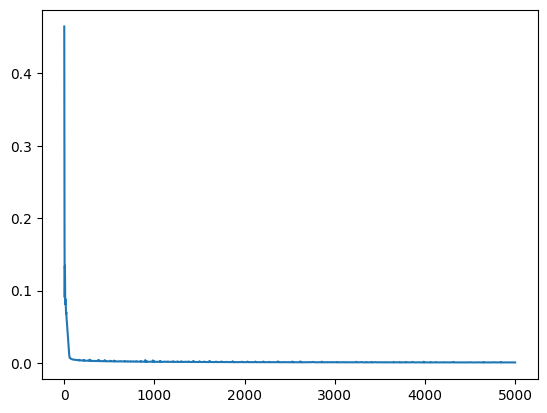

In [9]:
plt.plot(history.history['loss']);

1024/1024 [==============================] - 2s 1ms/step


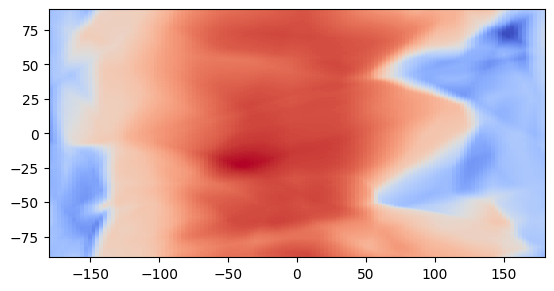

In [10]:
y_pred = model.predict(X_test_scaled) * (y_max - y_min) + y_min
plt.imshow(y_pred.reshape(256, 128), origin='lower', extent=[-180, 180, -90, 90], cmap='coolwarm', interpolation="none");

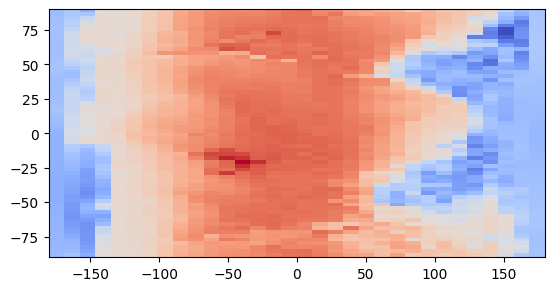

In [11]:
plt.imshow(y.reshape(64, 32), origin='lower', extent=[-180, 180, -90, 90], cmap='coolwarm', interpolation="none");

Text(0.5, 1.0, 'Diff')

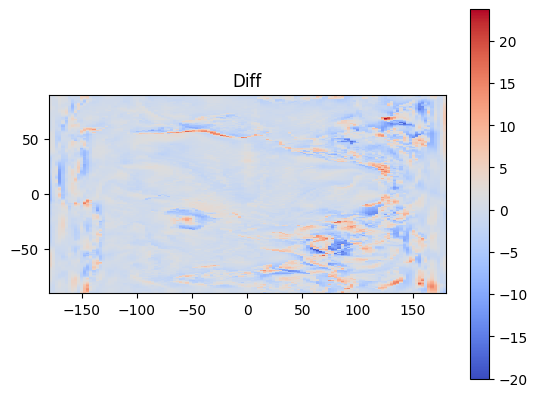

In [12]:
diff = y_pred.reshape(256, 128) - y_test.reshape(256, 128)
plt.imshow(diff, origin='lower', extent=[-180, 180, -90, 90], cmap='coolwarm', interpolation="none");
plt.colorbar();
plt.title("Diff")

In [13]:
# rmse = np.sqrt(np.mean(np.abs(X_test[:, 0:1])*(y_pred.ravel() - y_test.ravel())**2))/np.mean(y_test.ravel() * np.abs(X_test[:, 0:1]))
rmse = np.sqrt(np.mean((y_pred.ravel() - y_test.ravel())**2))
print(f"{rmse=}")

rmse=2.781035


In [14]:
mean_bias = np.mean(y_pred.ravel() - y_test.ravel())
print(f"{mean_bias=}")

mean_bias=-0.22927472
